<a href="https://colab.research.google.com/github/Ravikrishnan05/MLproject-/blob/main/Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#################################################################
# IMPROVED FLUX PIPELINE SCRIPT - Handles common failure points
#################################################################

# --- 1. ENVIRONMENT SETUP WITH VERSION PINNING ---
print("STEP 1: Installing specific library versions for compatibility...")
!pip install --upgrade --no-cache-dir diffusers>=0.21.0 transformers>=4.34.0 accelerate>=0.24.0 safetensors>=0.3.3
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
print("✅ Environment setup complete.")

# --- 2. SYSTEM INFO AND MEMORY CHECK ---
print("\nSTEP 2: Checking system resources...")
import torch
import gc
import psutil
import os

print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"RAM: {psutil.virtual_memory().total / 1e9:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1e9:.1f} GB")

# Clear any existing GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# --- 3. AUTHENTICATION ---
print("\nSTEP 3: Authenticating with Hugging Face...")
from huggingface_hub import login
from google.colab import userdata

try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN, add_to_git_credential=True)
    print("✅ Authentication successful.")
except Exception as e:
    print("🔴 Authentication failed. Please check your HF_TOKEN in Colab Secrets.")
    print(f"Error: {e}")
    raise

STEP 1: Installing specific library versions for compatibility...
Looking in indexes: https://download.pytorch.org/whl/cu118
✅ Environment setup complete.

STEP 2: Checking system resources...
GPU available: True
GPU: Tesla T4
VRAM: 15.8 GB
RAM: 13.6 GB
Available RAM: 12.1 GB

STEP 3: Authenticating with Hugging Face...
✅ Authentication successful.


In [3]:
# --- 4. LOAD PIPELINE WITH ROBUST ERROR HANDLING ---
print("\nSTEP 4: Loading FLUX pipeline with optimized settings...")
from diffusers import DiffusionPipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def load_flux_pipeline():
    """Load FLUX pipeline with multiple fallback strategies"""

    # Strategy 1: Full auto device mapping (ideal)
    try:
        print("Attempting full auto device mapping...")
        pipe = DiffusionPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-schnell",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            low_cpu_mem_usage=True,
            use_safetensors=True,
            variant="fp16"  # Use fp16 variant if available to save memory
        )
        print("✅ Success with auto device mapping!")
        return pipe
    except Exception as e:
        print(f"❌ Auto device mapping failed: {e}")

    # Strategy 2: Sequential CPU offload
    try:
        print("Attempting sequential CPU offload...")
        pipe = DiffusionPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-schnell",
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            use_safetensors=True
        )
        pipe.enable_sequential_cpu_offload()
        print("✅ Success with sequential CPU offload!")
        return pipe
    except Exception as e:
        print(f"❌ Sequential CPU offload failed: {e}")

    # Strategy 3: Model CPU offload
    try:
        print("Attempting model CPU offload...")
        pipe = DiffusionPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-schnell",
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            use_safetensors=True
        )
        pipe.enable_model_cpu_offload()
        print("✅ Success with model CPU offload!")
        return pipe
    except Exception as e:
        print(f"❌ Model CPU offload failed: {e}")

    # Strategy 4: CPU only (last resort)
    try:
        print("Attempting CPU-only loading...")
        pipe = DiffusionPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-schnell",
            torch_dtype=torch.float32,  # CPU doesn't support bfloat16 well
            low_cpu_mem_usage=True,
            use_safetensors=True
        )
        pipe = pipe.to("cpu")
        print("✅ Success with CPU-only mode!")
        return pipe
    except Exception as e:
        print(f"❌ All loading strategies failed: {e}")
        raise

# Load the pipeline
pipe = load_flux_pipeline()

# --- 5. MEMORY OPTIMIZATION ---
print("\nSTEP 5: Applying memory optimizations...")
try:
    # Enable attention slicing for memory efficiency
    pipe.enable_attention_slicing()
    print("✅ Attention slicing enabled")
except:
    print("⚠️ Could not enable attention slicing")

try:
    # Enable memory efficient attention if xformers is available
    pipe.enable_xformers_memory_efficient_attention()
    print("✅ xFormers memory efficient attention enabled")
except:
    print("⚠️ xFormers not available, using default attention")

# Final memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


STEP 4: Loading FLUX pipeline with optimized settings...
Attempting full auto device mapping...
❌ Auto device mapping failed: auto not supported. Supported strategies are: balanced, cuda
Attempting sequential CPU offload...


model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.95G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.96G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/774 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Success with sequential CPU offload!

STEP 5: Applying memory optimizations...
✅ Attention slicing enabled
⚠️ xFormers not available, using default attention


In [4]:
# --- 6. IMAGE GENERATION ---
print("\nSTEP 6: Generating image...")
from IPython.display import display

def generate_image(prompt, steps=1, guidance=0.0):
    """Generate image with error handling"""
    try:
        print(f"Generating: {prompt}")
        print(f"Steps: {steps}, Guidance: {guidance}")

        with torch.inference_mode():
            image = pipe(
                prompt=prompt,
                num_inference_steps=steps,
                guidance_scale=guidance,
                height=1024,
                width=1024,
                max_sequence_length=512,  # Limit sequence length to save memory
                generator=torch.Generator().manual_seed(42)  # For reproducible results
            ).images[0]

        return image
    except torch.cuda.OutOfMemoryError:
        print("🔴 GPU out of memory. Trying with smaller image size...")
        torch.cuda.empty_cache()
        gc.collect()

        # Try with smaller dimensions
        with torch.inference_mode():
            image = pipe(
                prompt=prompt,
                num_inference_steps=steps,
                guidance_scale=guidance,
                height=768,
                width=768,
                max_sequence_length=256,
                generator=torch.Generator().manual_seed(42)
            ).images[0]

        return image

# Generate the image
try:
    prompt = "A cinematic shot of a majestic lion wearing a crown on a throne, dramatic lighting, high detail"
    image = generate_image(prompt, steps=8, guidance=0.0)

    print("✅ Image generation successful!")
    display(image)

    # Save the image
    image.save("flux_output.png")
    print("✅ Image saved as 'flux_output.png'")

except Exception as e:
    print(f"🔴 Image generation failed: {e}")

    # Try with even more conservative settings
    print("Attempting generation with minimal settings...")
    try:
        image = generate_image("A simple lion", steps=4, guidance=0.0)
        display(image)
        image.save("flux_output_simple.png")
        print("✅ Simple image generation successful!")
    except Exception as e2:
        print(f"🔴 Even simple generation failed: {e2}")
        raise

print("\n🎉 Script completed successfully!")


STEP 6: Generating image...
Generating: A cinematic shot of a majestic lion wearing a crown on a throne, dramatic lighting, high detail
Steps: 8, Guidance: 0.0


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 


STEP 6: Generating image...
Generating: A cinematic shot of a majestic lion wearing a crown on a throne, dramatic lighting, high detail
Steps: 1, Guidance: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

✅ Image generation successful!


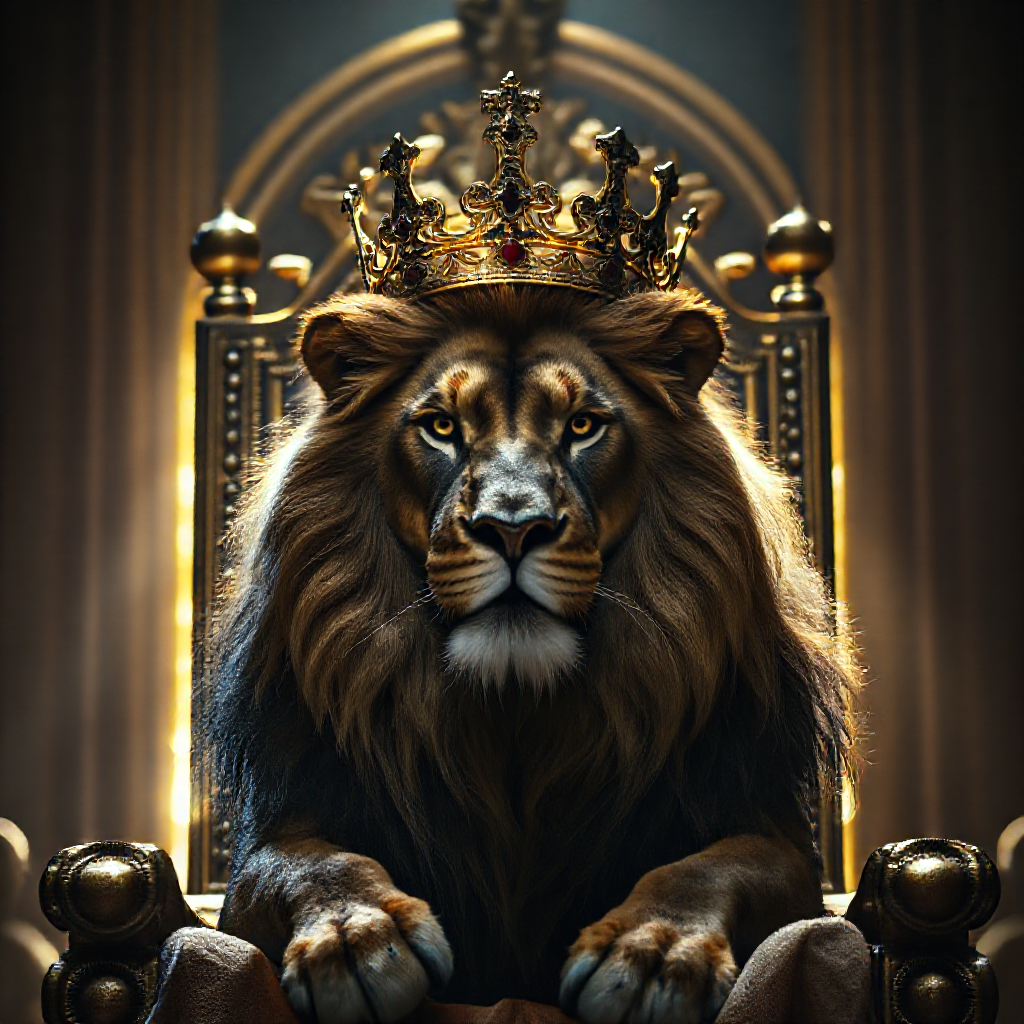

✅ Image saved as 'flux_output.png'

🎉 Script completed successfully!


In [5]:
# --- 6. IMAGE GENERATION ---
print("\nSTEP 6: Generating image...")
from IPython.display import display

def generate_image(prompt, steps=1, guidance=0.0):
    """Generate image with error handling"""
    try:
        print(f"Generating: {prompt}")
        print(f"Steps: {steps}, Guidance: {guidance}")

        with torch.inference_mode():
            image = pipe(
                prompt=prompt,
                num_inference_steps=steps,
                guidance_scale=guidance,
                height=1024,
                width=1024,
                max_sequence_length=512,  # Limit sequence length to save memory
                generator=torch.Generator().manual_seed(42)  # For reproducible results
            ).images[0]

        return image
    except torch.cuda.OutOfMemoryError:
        print("🔴 GPU out of memory. Trying with smaller image size...")
        torch.cuda.empty_cache()
        gc.collect()

        # Try with smaller dimensions
        with torch.inference_mode():
            image = pipe(
                prompt=prompt,
                num_inference_steps=steps,
                guidance_scale=guidance,
                height=768,
                width=768,
                max_sequence_length=256,
                generator=torch.Generator().manual_seed(42)
            ).images[0]

        return image

# Generate the image
try:
    prompt = "A cinematic shot of a majestic lion wearing a crown on a throne, dramatic lighting, high detail"
    image = generate_image(prompt, steps=1, guidance=0.0)

    print("✅ Image generation successful!")
    display(image)

    # Save the image
    image.save("flux_output.png")
    print("✅ Image saved as 'flux_output.png'")

except Exception as e:
    print(f"🔴 Image generation failed: {e}")

    # Try with even more conservative settings
    print("Attempting generation with minimal settings...")
    try:
        image = generate_image("A simple lion", steps=1, guidance=0.0)
        display(image)
        image.save("flux_output_simple.png")
        print("✅ Simple image generation successful!")
    except Exception as e2:
        print(f"🔴 Even simple generation failed: {e2}")
        raise

print("\n🎉 Script completed successfully!")